In [2]:
import sys
sys.path.append("../")

In [21]:
%load_ext autoreload
%autoreload 2
import os
import hashlib
import numpy as np
import traceback
from common.dataloader import load_dataset
from common import data_preprocess
from matplotlib import pyplot as plt
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def moving_average(data_dict, w):
    print(f"Moving average with w={w}")
    new_dict = defaultdict(list)
    for idx in range(data_dict["train"].shape[1]):
        new_dict["train"].append(np.convolve(data_dict["train"][:, idx], np.ones(w), 'valid') / w)
        new_dict["test"].append(np.convolve(data_dict["test"][:, idx], np.ones(w), 'valid') / w)
    
    new_dict["train"] = np.vstack(new_dict["train"]).T
    new_dict["test"] = np.vstack(new_dict["test"]).T
    new_dict["test_labels"] = data_dict["test_labels"]
    print(new_dict["train"].shape)
    return new_dict

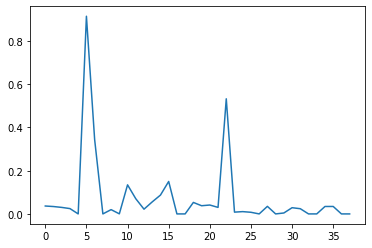

In [41]:
plt.plot(data_dict["train"][:, 0])

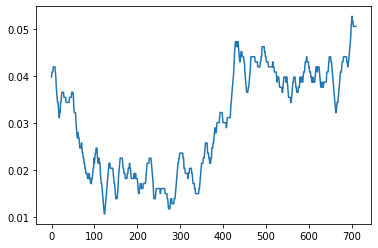

In [18]:
plt.plot(moving_average(data_dict["train"][:, 0], 10))

In [ ]:
dataset = "SMD" # change to HUAWEI
subdatasets = ["machine-1-1"] # Change to all hashid list
ma_size = 5 # -1 means 
window_size = 50
stride = 50
plt.tight_layout()
for concerned_type in ["normal", "anomaly"]:
    outdir = os.path.join("empirical_study", f"{concerned_type}_{dataset}_ma_{ma_size}_empirical")
    for subdataset in subdatasets:
        current_out = os.path.join(outdir, subdataset) 
        print(f"Plotting to {current_out}")
        os.makedirs(current_out, exist_ok=True)
        data_dict = load_dataset(dataset, subdataset, "all", root_dir="../", nrows=720)
        
        if ma_size != -1:
            data_dict = moving_average(data_dict, w=ma_size)
            
        window_dict = data_preprocess.generate_windows(
                    data_dict,
                    window_size=window_size,
                    stride=stride,
                    test_stride=stride
                )
        windows = window_dict["test_windows"]

        anomaly_indice = np.any(window_dict["test_labels"], axis=1)
        normal_indice = ~anomaly_indice

        print(windows.shape, anomaly_indice.shape, normal_indice.shape)

        anomaly = windows[anomaly_indice]
        normal = windows[normal_indice]

        concerned_window = anomaly if concerned_type == "anomaly" else normal
        for win_idx, window in enumerate(concerned_window):
            fig, ax = plt.subplots(window.shape[1], figsize=(20, 6*len(window)))
            for idx in range(window.shape[1]):
                data = window[:, idx]
                ax[idx].plot(data, label=f"{subdataset} | {concerned_type} | win_{win_idx} | dim_{idx}")
                ax[idx].legend()
            fig.savefig(os.path.join(current_out, f"win_{win_idx}.pdf"), bbox_inches="tight")
            plt.close()
        print(f"===============Finish {subdataset} {concerned_type} part===============")

Plotting to empirical_study/normal_SMD_ma_5_empirical/machine-1-1
Loading machine-1-1 of SMD dataset
.././datasets/anomaly/SMD/processed/machine-1-1_train.pkl
Shape of train is (720, 38).
Shape of test is (720, 38).
Shape of test_labels is (720,).
Moving average with w=5
(716, 38)
train (716, 38)
test (716, 38)
test_labels (720,)
Generating sliding windows (size 50, stride 50, test stride 50).
Train windows #: (14, 50, 38)
Test windows #: (14, 50, 38)
(14, 50, 38) (14,) (14,)
